<a href="https://colab.research.google.com/github/JelenaBanjac/protein-reconstruction/blob/master/notebooks/2-phase2/colab_distance_estimation_and_angle_recovery-test5j0nhalf-cov_noisy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distance Estimation and Angle Recovery

<div class="alert alert-danger" role="alert">
  <p><strong>Important:</strong> This notebook is used to run the distance estimation on noisy data only (no angle recovery).</p>
  <hr>
    - <b>To enable GPU</b>: Navigate to Edit→Notebook Settings<br/>
    - <b>To save the latest version of code from this notebook</b>: Navigate to File→Save a copy to Github.
</div>

## Content

1. [Data Preparation](#1.-Data-Preparation)
2. [Distance Estimation](#2.-Distance-Estimation)
3. [Angle Recovery](#3.-Angle-Recovery)
4. [Angle Alignment](#4.-Angle-Alignment)

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [ ]:
# create directories
!mkdir --parents data/5j0n
!mkdir training

## Setup Environment (Colab)

Link to MiniConda Linux installer [here](https://docs.conda.io/en/latest/miniconda.html).

In [ ]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
# clone repo
!rm -r protein-reconstruction
!git clone https://github.com/JelenaBanjac/protein-reconstruction.git
!cd protein-reconstruction

In [ ]:
# download dataset
# TODO: put here the link
# e.g.: !curl https://transfer.sh/N3J6C/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5 -o data/5j0n/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5

In [ ]:
#!conda env create -f environment.yml 
!conda install -q -y --prefix /usr/local -c conda-forge ipyvolume
!pip3 install tensorflow-graphics-gpu

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append("protein-reconstruction") 

In [ ]:
!python --version

## Start the Pipeline

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd


from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8492676108236968159
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 367098670719913763
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10990574109414875861
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 7455704990558429202
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


In [5]:
PROTEIN="5j0n"
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "data/5j0n/"

# TODO: dataset name
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [1]:
#plot_images(angles_true, projections, range(100), img_size_scale=0.05)

In [2]:
#ipv.screenshot()

---

## Prepare for training

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [11]:
from cryoem.distance_estimation import global_standardization

In [12]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [13]:
test_size = 0.33
val_size = 0.25

In [15]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=test_size, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=val_size, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_noisy_idx", train_idx, val_idx, test_idx)

In [16]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [14]:
data = np.load("data/5j0n/5j0n_siamese_noisy_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [15]:
X = np.stack((X,)*3, axis=-1)

In [16]:
X.shape

(5000, 116, 116, 3)

# 1. Distance Estimation

### Train the model

In [17]:
from time import time

In [18]:
# CALCULATE FULL 
from tensorflow.keras.utils import Sequence

num_dec = 1
num_bins = 32

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
  
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
                bins[np.around(label, num_dec)].append([idx1, idx2])

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)

        # [training_pairs[:, 0], training_pairs[:, 1]], labels
        return [pairs[:, 0], pairs[:, 1]], labels 
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)     

In [19]:
import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    input_x = Input(shape=input_shape)
    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_x, input_shape=input_shape)
    x = base_model.layers[-1].output

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)

    return Model(input_x, x)

def create_distance_network(input_shape):
    # ref: https://github.com/guanjianyu/DisNet/blob/master/Train_DisNet.py
    # ref: https://project.inria.fr/ppniv18/files/2018/10/paper22.pdf
    input_x = Input(shape=input_shape)
   
    x = Dense(2000, activation="relu")(input_x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    
    return Model(input_x, x)



def train_siamese(X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        dP_values = d_p(p1, p2).T[0]
        dQ_values = d_q(q1_true, q2_true).numpy()

        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            #plt.clf()
            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style="uniform", shuffle=True)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style="uniform", shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        m = Model([input_a, input_b], distance)  # was m

        global model
        # train
        model = multi_gpu_model(m, gpus=gpus)
        model.summary()
        plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
        
        # Setup callbacks
        LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))

        history1 = model.fit(training_generator, 
                            epochs=epochs_top,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback])
        
        
        if plot:
            # Get training and test loss histories
            training_loss = history1.history['loss']
            val_loss = history1.history['val_loss']
            mses = history1.history['mse']
            val_mses = history1.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")

        return model, history1

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [21]:
train_percent = 0.1
val_percent = 0.1
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(631014, 70224)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Data created in 4.466503858566284 sec
Data created in 0.4941675662994385 sec
Input images shape (116, 116, 3)


/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 27/200
37/37 [==============================] - 31s 836ms/step - loss: 1.2019 - mse: 1.0553 - val_loss: 1.8883 - val_mse: 1.5591
Epoch 28/200
37/37 [==============================] - 30s 824ms/step - loss: 1.1388 - mse: 1.0142 - val_loss: 1.3702 - val_mse: 1.0544
Epoch 29/200
37/37 [==============================] - 31s 844ms/step - loss: 1.1679 - mse: 1.0419 - val_loss: 1.3806 - val_mse: 1.1054
Epoch 30/200
37/37 [==============================] - 31s 829ms/step - loss: 1.1799 - mse: 1.0463 - val_loss: 1.3714 - val_mse: 1.1705
Epoch 31/200
37/37 [==============================] - 31s 832ms/step - loss: 1.1972 - mse: 1.0626 - val_loss: 0.9974 - val_mse: 0.7098
Epoch 32/200
37/37 [==============================] - 31s 829ms/step - loss: 1.1468 - mse: 1.0125 - val_loss: 1.6252 - val_mse: 1.4429
Epoch 33/200
37/37 [==============================] - 31s 839ms/step - loss: 1.1306 - mse: 0.9839 - val_loss: 1.4315 - val_mse: 1.2266
Epoch 34/200
37/37 [==============================] - 3

Epoch 88/200
37/37 [==============================] - 31s 842ms/step - loss: 0.6765 - mse: 0.5758 - val_loss: 1.6599 - val_mse: 1.4361
Epoch 89/200
37/37 [==============================] - 31s 841ms/step - loss: 0.6639 - mse: 0.5705 - val_loss: 1.6295 - val_mse: 1.4164
Epoch 90/200
37/37 [==============================] - 30s 820ms/step - loss: 0.6372 - mse: 0.5447 - val_loss: 1.5301 - val_mse: 1.3420
Epoch 91/200
37/37 [==============================] - 31s 835ms/step - loss: 0.6679 - mse: 0.5664 - val_loss: 1.4831 - val_mse: 1.2074
Epoch 92/200
37/37 [==============================] - 31s 844ms/step - loss: 0.6235 - mse: 0.5302 - val_loss: 1.4826 - val_mse: 1.2698
Epoch 93/200
37/37 [==============================] - 31s 846ms/step - loss: 0.6244 - mse: 0.5270 - val_loss: 1.7739 - val_mse: 1.5730
Epoch 94/200
37/37 [==============================] - 30s 820ms/step - loss: 0.6970 - mse: 0.6030 - val_loss: 1.7288 - val_mse: 1.5172
Epoch 95/200
37/37 [==============================] - 3

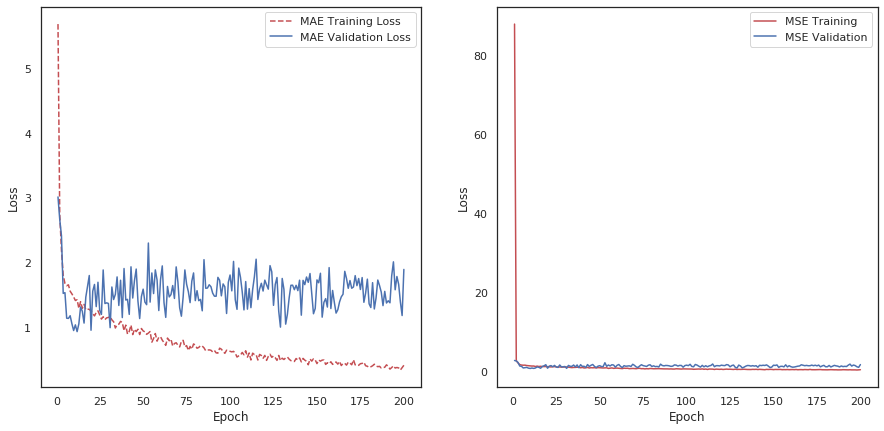

Model saved to: training/20200601_022855.h5


In [23]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=200,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=1)

---

In [35]:
training_loss = history1.history['loss']
val_loss = history1.history['val_loss']
mses = history1.history['mse']
val_mses = history1.history['val_mse']

np.savez("data/5j0n/5j0n_DE_noisy_history_uniform", training_loss, val_loss, mses, val_mses)

In [36]:
data = np.load("data/5j0n/5j0n_DE_noisy_history_uniform.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

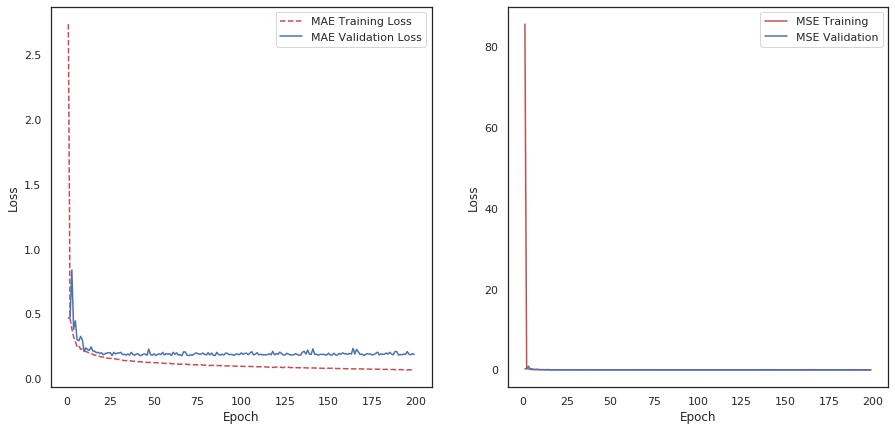

In [38]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [39]:
training_loss[-1], val_loss[-1], mses[-1], val_mses[-1]

(0.06818553585162278, 0.18914438287417093, 0.009661273, 0.06259676)

In [ ]:
# save the model on the drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!cd 'drive/My Drive'
!mkdir ModelsProtein

In [ ]:
model_filename = f"{strftime('%Y%m%d_%H%M%S')}.h5"
model.save(f"/content/drive/My Drive/{model_filename}")

### (Or) Read model checkpoint

In [20]:
# put correct filename
# model_filename = "training/20200531_224202.h5"

In [21]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 116, 116, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 116, 116, 3)  0           input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
# OR Upload the model instead of saving it to drive
# TODO: put a correct model name
# !curl --upload-file training/20200531_224202.h5 https://transfer.sh/20200531_224202.h5

---

## dP/dQ plot

In [22]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [23]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [24]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

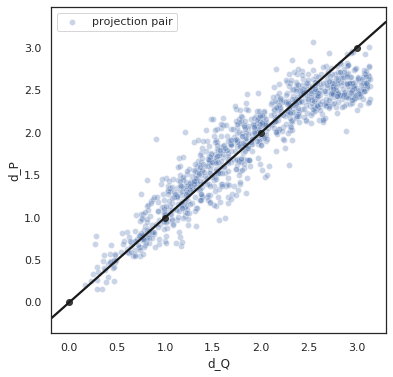

<Figure size 432x288 with 0 Axes>

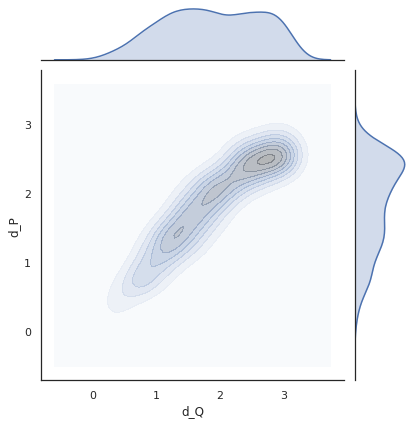

Variance = 0.2690672323834601
Min. angle recovery loss possible = 0.07232477836695243


In [25]:
plot_dP_dQ(dP_values, dQ_values)

In [26]:
MAE(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21109173>